In [1]:
import numpy as np
import pickle
import pandas as pd
import os
from os.path import join
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score
from scipy import stats
import xgboost as xgb
from hyperopt import fmin, rand, hp, Trials, tpe
# rstate = np.random.default_rng(42)
import random
# random.set_seed(10)

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl

datasets_dir = "../../data"
# plt.style.use('CCB_plot_style_0v4.mplstyle')
# c_styles      = mpl.rcParams['axes.prop_cycle'].by_key()['color']   # fetch the defined color styles
# high_contrast = ['#004488', '#DDAA33', '#BB5566', '#000000']

## Loading training and test data:

In [2]:
split = "Arabidopsis"

data_train = pd.read_pickle(join(datasets_dir, "splits", split, "training_data.pkl"))
data_test = pd.read_pickle(join(datasets_dir, "splits", split, "test_data.pkl"))
data_val = pd.read_pickle(join(datasets_dir, "splits", split, "val_data.pkl"))

# data_train["geomean_kcat"] = np.log10(data_train["geomean_kcat"])
# data_test["geomean_kcat"] = np.log10(data_test["geomean_kcat"])

data_train["log10_kcat"] = np.log10(data_train["kcat"])
data_test["log10_kcat"] = np.log10(data_test["kcat"])
data_val["log10_kcat"] = np.log10(data_val["kcat"])

data_train.rename(columns = {"Enzyme rep" : "ESM2"}, inplace = True)
data_test.rename(columns = {"Enzyme rep" : "ESM2"}, inplace = True)
data_val.rename(columns = {"Enzyme rep" : "ESM2"}, inplace = True)

data_train['Temperature'] = data_train['Temperature'].replace('-', np.nan)
data_test['Temperature'] = data_test['Temperature'].replace('-', np.nan)
data_val['Temperature'] = data_val['Temperature'].replace('-', np.nan)
data_train['pH'] = data_train['pH'].replace('-', np.nan)
data_test['pH'] = data_test['pH'].replace('-', np.nan)
data_val['pH'] = data_val['pH'].replace('-', np.nan)
data_train['Type'] = data_train['Type'].replace('wildtype', 1)
data_train['Type'] = data_train['Type'].replace('mutant', 2)
data_test['Type'] = data_test['Type'].replace('wildtype', 1)
data_test['Type'] = data_test['Type'].replace('mutant', 2)
data_val['Type'] = data_val['Type'].replace('wildtype', 1)
data_val['Type'] = data_val['Type'].replace('mutant', 2)

data_train['MACCS FP'] = data_train['MACCS FP'].astype(str)
data_test['MACCS FP'] = data_test['MACCS FP'].astype(str)
data_val['MACCS FP'] = data_val['MACCS FP'].astype(str)

len(data_train), len(data_test), len(data_val)

(327, 63, 7)

In [3]:
train_indices = list(np.load(join(datasets_dir, "splits", split, "CV_train_indices_Seed plants.npy"), allow_pickle = True))
test_indices = list(np.load(join(datasets_dir, "splits", split, "CV_test_indices_Seed plants.npy"), allow_pickle = True))

In [4]:
data_test = data_test[~data_test['GNN FP'].isnull()]

nan_rows = data_train[data_train['GNN FP'].apply(lambda x: not isinstance(x, np.ndarray))]

# Get the indices of these rows
indices_with_nan = nan_rows.index.tolist()
# indices_with_nan.reverse()
print(indices_with_nan)

for ind, sub_list in enumerate(train_indices):
    for elem in sub_list:
        if elem in indices_with_nan:
            sub_list.remove(elem)

for ind, sub_list in enumerate(train_indices):
    for num in indices_with_nan:
        for i, elem in enumerate(sub_list):
            if elem > num:
                train_indices[ind][i] = elem-1

for ind, sub_list in enumerate(test_indices):
    for elem in sub_list:
        if elem in indices_with_nan:
            sub_list.remove(elem)

for ind, sub_list in enumerate(test_indices):
    for num in indices_with_nan:
        for i, elem in enumerate(sub_list):
            if elem > num:
                test_indices[ind][i] = elem-1  


data_train = data_train[data_train['GNN FP'].apply(lambda x: isinstance(x, np.ndarray))]
data_train.reset_index(inplace=True, drop=True)

[36, 297]


## 1. Training a model with enzyme and substrate information (ESM-2/MACCS) + Temperature + pH:

#### (a) Creating input matrices:

In [5]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [6]:
def cross_validation_mse_gradient_boosting(param):
    num_round = param["num_rounds"]
    del param["num_rounds"]
    param["max_depth"] = int(np.round(param["max_depth"]))
    # param["device"] = "cuda"
    param["tree_method"] = "gpu_hist"
    param["sampling_method"] = "gradient_based"
    
    MSE = []
    R2 = []
    for i in range(5):
        train_index, test_index  = train_indices[i], test_indices[i]
        dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
        dvalid = xgb.DMatrix(train_X[test_index])
        bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
        y_valid_pred = bst.predict(dvalid)
        MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
        R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
    return(-np.mean(R2))

space_gradient_boosting = {
    "learning_rate": hp.choice("learning_rate", [0.01,0.1,0.2]),
    "max_depth": hp.quniform("max_depth", 3, 10, 1),
    # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
    "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
    "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
    "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
    "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
    "num_rounds":  hp.choice("num_rounds", [100,250,500,1000])
    }

rstate = np.random.default_rng(42)
trials = Trials()
best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
            algo=rand.suggest, max_evals = 20, trials=trials, return_argmin=False, rstate=rstate)

print(best)
param = best
param["random_state"] = 42

100%|██████████| 20/20 [55:00<00:00, 165.02s/trial, best loss: -0.36153634838502613]
{'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.2, 'reg_lambda': 0.4}


In [7]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 1000, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
# elif split == "Brassicaceae":
#     param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 1.0, 'max_depth': 3.0, 'min_child_weight': 5.0, 'num_rounds': 1000.0, 'reg_alpha': 0.4, 'reg_lambda': 0.4}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
else:
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 1.0, 'max_depth': 8.0, 'min_child_weight': 4.0, 'num_rounds': 250, 'reg_alpha': 0.6, 'reg_lambda': 0.8}


#### (c) Training and validating model:

In [8]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [9]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_EMS2_gnn_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_EMS2_gnn_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_EMS2_gnn_fp.npy"), np.array(R2))

[0.600510594158696, 0.055882301076098616, 0.6235994848344643, 0.23218726472198728, 0.8805010913239415]
[118.49905364265858, 112.12569139656746, 84.47627020751302, 145.82168991688937, 204.13036339077001]
[-2.7691541636350476, -0.04547290151900252, 0.26765750913150976, -0.17941047349213024, 0.2632065849003612]
[34.47630719797568, 28.512665245541644, 33.35607064918293, 65.76665947241528, 56.819065508557564]
[2.577768809875434, 2.0170675948018895, 4.61499682667775, 6.829325810151079, 4.1813462257111835]


In [10]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))
# MedAE = np.median(abs(np.array(test_Y) - np.array(y_test_pred)))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))

np.save(join("..", "..", "data", "y_test_pred_xgboost_EMS2_gnn_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_EMS2_gnn_fp.npy"), test_Y)

0.829 175.7169146681 0.597 56.7171322376 4.9061913792


In [11]:
y_test_pred_esm1b_ts_drfp = y_test_pred

In [12]:
pd.DataFrame(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))).describe()

,0
count,63.000000
mean,56.717132
std,167.647617
min,0.007965
25%,0.728677
50%,4.906191
75%,26.737721
max,1176.979311


#### (d) Training model with test and train data for production mode:

In [13]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [14]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.9575163015175675, 1.2120513776724916e-34) 80.83749401592237 0.91464708364087


##### Validating model

In [15]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["GNN FP"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

In [16]:
dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

(-0.14326340856715858, 0.7592766667273674) 40.966750253419676 -89.90199313680726 29.506860235855218 24.526388564683554


## 2. Training a model with enzyme and reaction information (ESM-2/diff_fp) + Temperature + pH:

#### (a) Creating input matrices:

In [17]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [18]:
def cross_validation_mse_gradient_boosting(param):
    num_round = param["num_rounds"]
    del param["num_rounds"]
    param["max_depth"] = int(np.round(param["max_depth"]))
    # param["device"] = "cuda"
    param["tree_method"] = "gpu_hist"
    param["sampling_method"] = "gradient_based"
    
    MSE = []
    R2 = []
    for i in range(5):
        train_index, test_index  = train_indices[i], test_indices[i]
        dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
        dvalid = xgb.DMatrix(train_X[test_index])
        bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
        y_valid_pred = bst.predict(dvalid)
        MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
        R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
    return(-np.mean(R2))

space_gradient_boosting = {
    "learning_rate": hp.choice("learning_rate", [0.01,0.1,0.2]),
    "max_depth": hp.quniform("max_depth", 3, 10, 1),
    # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
    "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
    "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
    "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
    "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
    "num_rounds":  hp.choice("num_rounds", [100,250,500,1000])
    }

rstate = np.random.default_rng(42)
trials = Trials()
best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
            algo=rand.suggest, max_evals = 20, trials=trials, return_argmin=False, rstate=rstate)

print(best)
param = best
param["random_state"] = 42

100%|██████████| 20/20 [1:55:45<00:00, 347.27s/trial, best loss: -0.3091125238752824]  
{'learning_rate': 0.2, 'max_delta_step': 2.0, 'max_depth': 5.0, 'min_child_weight': 3.0, 'num_rounds': 250, 'reg_alpha': 0.8, 'reg_lambda': 0.8}


In [19]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 2.0, 'max_depth': 5.0, 'min_child_weight': 3.0, 'num_rounds': 250, 'reg_alpha': 0.8, 'reg_lambda': 0.8}
# elif split == "Brassicaceae":
#     param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 750.0, 'reg_alpha': 0.4, 'reg_lambda': 0.4}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 4.0, 'max_depth': 4.0, 'min_child_weight': 3.0, 'num_rounds': 100, 'reg_alpha': 0.8, 'reg_lambda': 0.0}
else:
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 1000, 'reg_alpha': 0.2, 'reg_lambda': 0.4}

#### (c) Training and validating model:

In [20]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [21]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_EMS2_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_EMS2_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_EMS2_diff_fp.npy"), np.array(R2))

[0.5622898170075521, 0.0439977052434941, 0.6770977046356558, 0.27292267464888004, 0.5388149007718198]
[106.02760124193702, 115.40840105158323, 80.68241116667211, 143.08961203645993, 224.62257632692538]
[-2.017532867669647, -0.10758575238642565, 0.33195993674281, -0.1356302138566714, 0.1078511363546979]
[31.35414557290776, 30.48607721666991, 31.18871444775383, 63.40295869754336, 65.48940846416303]
[2.1142029373729185, 2.172053456346441, 2.9939698372515373, 4.054365177022721, 3.626520181546664]


In [22]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)
MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))

np.save(join("..", "..", "data", "y_test_pred_xgboost_EMS2_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_EMS2_diff_fp.npy"), test_Y)

0.766 198.0645793739 0.488 60.6241881297 5.2231928373


In [23]:
y_test_pred_esm1b_ts_drfp = y_test_pred

#### (d) Training model with test and train data for production mode:

In [24]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [25]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.9571430359645865, 1.5740937467853395e-34) 80.91820407004494 0.914476561841007


##### Validating model

In [26]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["difference_fp"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

In [27]:
dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

(0.7733331260960565, 0.04140405749108588) 11.296670347834683 -5.9121203060866465 9.1784889983758 11.290117171435282


## 3. Training a model with enzyme, substrate (MACCS fp) and reaction information (ESM-2/diff_fp) + Temperature + pH:

#### (a) Creating input matrices:

In [28]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [29]:
def cross_validation_mse_gradient_boosting(param):
    num_round = param["num_rounds"]
    del param["num_rounds"]
    param["max_depth"] = int(np.round(param["max_depth"]))
    # param["device"] = "cuda"
    param["tree_method"] = "gpu_hist"
    param["sampling_method"] = "gradient_based"
    
    MSE = []
    R2 = []
    for i in range(5):
        train_index, test_index  = train_indices[i], test_indices[i]
        dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
        dvalid = xgb.DMatrix(train_X[test_index])
        bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
        y_valid_pred = bst.predict(dvalid)
        MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
        R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
    return(-np.mean(R2))

space_gradient_boosting = {
    "learning_rate": hp.choice("learning_rate", [0.01,0.1,0.2]),
    "max_depth": hp.quniform("max_depth", 3, 10, 1),
    # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
    "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
    "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
    "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
    "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
    "num_rounds":  hp.choice("num_rounds", [100,250,500,1000])
    }

rstate = np.random.default_rng(42)
trials = Trials()
best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
            algo=rand.suggest, max_evals = 20, trials=trials, return_argmin=False, rstate=rstate)

print(best)
param = best
param["random_state"] = 42

100%|██████████| 20/20 [2:01:28<00:00, 364.41s/trial, best loss: -0.3269220928246963]  
{'learning_rate': 0.01, 'max_delta_step': 1.0, 'max_depth': 9.0, 'min_child_weight': 3.0, 'num_rounds': 250, 'reg_alpha': 1.0, 'reg_lambda': 0.8}


In [30]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 1000, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 1.0, 'max_depth': 9.0, 'min_child_weight': 3.0, 'num_rounds': 250, 'reg_alpha': 1.0, 'reg_lambda': 0.8}
# elif split == "Brassicaceae":
#     param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 3.0, 'min_child_weight': 6.0, 'num_rounds': 750.0, 'reg_alpha': 0.8, 'reg_lambda': 0.6}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 1000, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
else:
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 1.0, 'max_depth': 7.0, 'min_child_weight': 1.0, 'num_rounds': 1000, 'reg_alpha': 0.6, 'reg_lambda': 0.4}

#### (c) Training and validating model:

In [31]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [32]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_EMS2_gnn_fp_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_EMS2_gnn_fp_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_EMS2_gnn_fp_diff_fp.npy"), np.array(R2))

[0.5482907464190918, 0.15108067661068803, 0.6628073626250883, 0.18788974617296483, 0.7519023413021684]
[104.42975308124876, 110.07312977899024, 77.55098039299952, 148.19781356475124, 210.62340327676918]
[-1.9272690390230576, -0.007546602360528398, 0.38280932395064704, -0.21815995561513035, 0.21558882860828998]
[31.354145782396824, 26.775478580489416, 28.41563178652903, 67.98284394885708, 59.50473133210782]
[2.127266608565856, 1.5867976670759334, 6.064025686626269, 7.230549286463678, 4.28426795511715]


In [33]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)
MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))

np.save(join("..", "..", "data", "y_test_pred_xgboost_EMS2_gnn_fp_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_EMS2_gnn_fp_diff_fp.npy"), test_Y)

0.757 190.7806872221 0.525 58.8768456747 4.6944053623


In [34]:
y_test_pred_esm1b_ts_drfp = y_test_pred

#### (d) Training model with test and train data for production mode:

In [35]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [36]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.9572889240267137, 1.4216309244204366e-34) 81.70332815297654 0.9128088960159864


In [37]:
importances = bst.get_score()

In [38]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["difference_fp"])), np.array(list(data_val["GNN FP"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

In [39]:
dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

(0.5068010898466797, 0.2457218769259701) 19.054206649417196 -18.664917065139218 15.572595683449915 14.055282670374776


In [40]:
data_val["Estimate kcat"] = y_val_pred

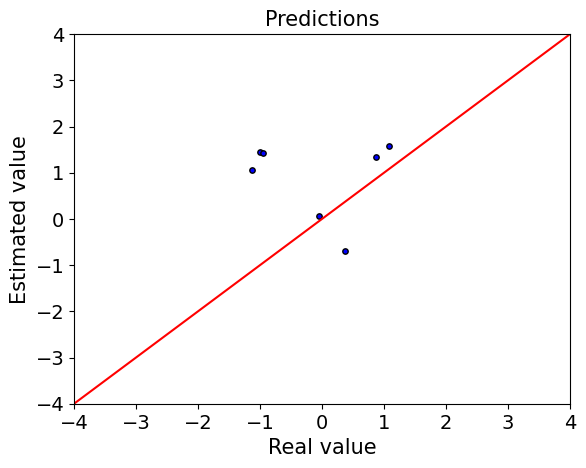

In [41]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

plt.scatter(val_Y,y_val_pred,c='blue', edgecolors='black',s=15)
    
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Real value', fontsize=15)
plt.ylabel('Estimated value', fontsize=15)
plt.title('Predictions', fontsize=15)
plt.axline((1, 1), slope=1, c='red')
plt.show()

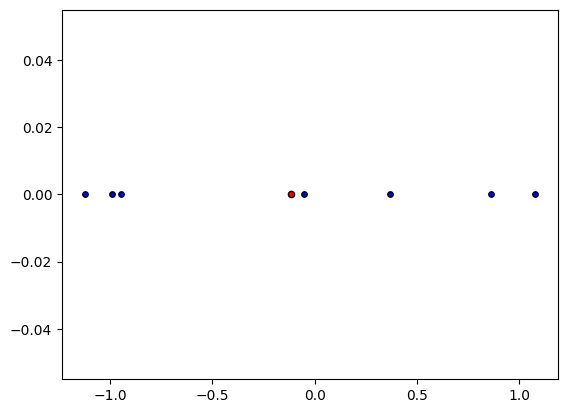

In [42]:
plt.scatter(val_Y, np.zeros_like(val_Y), c='blue', edgecolors='black',s=15)
plt.scatter(np.mean(val_Y), 0, c='red', edgecolors='black',s=20)

In [43]:
importances = bst.get_score()

In [44]:
print(len(data_train["ESM2"][1]))
print(len(data_train["difference_fp"][1]))
print(len(data_train["MACCS FP"][1]))

1280
2048
167


In [45]:
importances

{'f0': 53.0,
 'f1': 21.0,
 'f2': 21.0,
 'f3': 12.0,
 'f4': 11.0,
 'f5': 9.0,
 'f6': 10.0,
 'f7': 9.0,
 'f8': 2.0,
 'f9': 4.0,
 'f10': 11.0,
 'f11': 4.0,
 'f12': 2.0,
 'f14': 10.0,
 'f15': 1.0,
 'f16': 5.0,
 'f17': 1.0,
 'f18': 2.0,
 'f19': 5.0,
 'f20': 1.0,
 'f21': 3.0,
 'f22': 3.0,
 'f23': 2.0,
 'f24': 3.0,
 'f25': 1.0,
 'f26': 3.0,
 'f27': 1.0,
 'f28': 1.0,
 'f29': 1.0,
 'f30': 2.0,
 'f31': 2.0,
 'f32': 1.0,
 'f33': 3.0,
 'f34': 1.0,
 'f35': 3.0,
 'f37': 1.0,
 'f38': 2.0,
 'f39': 2.0,
 'f40': 1.0,
 'f41': 1.0,
 'f42': 1.0,
 'f43': 3.0,
 'f44': 5.0,
 'f45': 1.0,
 'f46': 3.0,
 'f49': 1.0,
 'f52': 2.0,
 'f54': 2.0,
 'f58': 1.0,
 'f60': 1.0,
 'f61': 1.0,
 'f62': 5.0,
 'f65': 1.0,
 'f66': 1.0,
 'f67': 1.0,
 'f68': 1.0,
 'f69': 2.0,
 'f71': 1.0,
 'f72': 2.0,
 'f74': 6.0,
 'f75': 2.0,
 'f76': 2.0,
 'f77': 1.0,
 'f78': 1.0,
 'f81': 1.0,
 'f82': 5.0,
 'f83': 1.0,
 'f85': 1.0,
 'f86': 1.0,
 'f87': 1.0,
 'f91': 2.0,
 'f94': 3.0,
 'f95': 1.0,
 'f96': 1.0,
 'f98': 3.0,
 'f101': 1.0,
 'f102': 2.0,

In [46]:
# data_combined = pd.concat([data_train, data_test],ignore_index=True)


In [47]:
# plt.hist([10**x for x in data_combined["log10_kcat"]], bins=50, color='skyblue', edgecolor='black')

In [48]:
# plt.hist([10**x for x in data_val["log10_kcat"]], bins=50, color='skyblue', edgecolor='black')

In [49]:
# def calculate_identity_ignore_gaps(seq1, seq2):
#     identical_residues = sum([1 for x, y in zip(seq1, seq2) if x == y and x != "-"])
#     pid = identical_residues / sum([1 for x in seq1 if x != "-"]) 
#     return pid

# from Bio import Align
# from Bio.Align import substitution_matrices

# data_val["max_identity"] = np.nan

# aligner=Align.PairwiseAligner()
# aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")
# aligner.mode = "global"
# aligner.extend_gap_score = -0.5
# aligner.open_gap_score = -10

# for i in data_val.index:
#     identities = []
#     for j in data_combined.index:
#         seq1 = str(data_val["Sequence"][i])
#         seq2 = str(data_combined["Sequence"][j])
#         if 'U' in seq1:
#             seq1 = seq1.replace('U', 'C')
#         if 'U' in seq2:
#             seq2 = seq2.replace('U', 'C')
#         alignments = aligner.align(seq1, seq2)
#         identities.append(calculate_identity_ignore_gaps(alignments[0][0], alignments[0][1]))
#     data_val["max_identity"][i] = max(identities)

In [50]:
# data_val["max_identity"] = data_val["max_identity"]*100

In [51]:
# import matplotlib.pyplot as plt
# import sklearn.metrics as sk
# import math

# fig, ax = plt.subplots(figsize= (10,8))
# plt.rcParams.update({'font.size': 28})

# splits = ["0-40%", "40-80%", "80-99%"]
# lower_bounds = [0,40,80]
# upper_bounds = [40,80,99]

# points1 = []
# points2 = []
# n_points1, n_points2 = [], []

# for i, split in enumerate(splits):

#     lb, ub = lower_bounds[i], upper_bounds[i]
    
#     help_df = data_val.loc[data_val["max_identity"]>= lb].loc[data_val["max_identity"]<= ub]
#     y_true = np.array([10**x for x in help_df["log10_kcat"]])
#     y_pred = np.array([10**x for x in help_df["Estimate kcat"]])
#     n_kcat = len(y_pred)
#     R2 =  sk.r2_score(y_true, y_pred)
#     abs_error = abs(y_true - y_pred)
#     rmse = math.sqrt(np.mean(abs(y_true - y_pred)**2))
#     print(len(y_true))
#     print(split, R2, rmse)
#     points1.append(R2)
#     points2.append(rmse)
#     n_points1.append(n_kcat)


# ticks2 = np.array(range(len(splits)))
# labs = splits
# ax.set_xticks(ticks2)
# ax.set_xticklabels(labs,  y= -0.03, fontsize=26)
# ax.tick_params(axis='x', length=0, rotation = 0)

# # plt.ylim((-0.1,2.5))
# # plt.xlim((-0.2, 3.2))
# plt.legend(loc = "lower right", fontsize=20)
# plt.ylabel('RMSE')
# plt.xlabel('Enzyme sequence identity')
# # ax.yaxis.set_label_coords(-0.15, 0.5)
# # ax.xaxis.set_label_coords(0.5,-0.13)

# plt.plot([-0.15,4], [0,0], color='grey', linestyle='dashed')


# plt.plot([0,1,2], points2, c= "black", linewidth=2)

# for i, split in enumerate(splits):
#     points1.append(R2)
    
#     if i ==0:
#         plt.scatter(i, points2[i], c='black', marker="o", linewidths= 8)
#         ax.annotate(n_points1[i], (i-0.08, points2[i]+0.08), fontsize=17, c= "red", weight = "bold")

#     else:
#         plt.scatter(i, points2[i], c='black', marker="o", linewidths= 8)
#         ax.annotate(n_points1[i], (i-0.08, points2[i]+0.08), fontsize=17, c= "red", weight = "bold")
            
     
# plt.savefig(join("..","..", "data", "sequence_identity.png"))
# plt.show()

In [52]:
# EC_kcat_pred =[[] for _ in range(6)]
# EC_kcat =[[] for _ in range(6)]
# for ind in data_val.index:
#     try:
#         EC = int(data_val["ECs"][ind][0][0])
#         EC_kcat[EC-1].append(data_val["log10_kcat"][ind])
#         EC_kcat_pred[EC-1].append(data_val["Estimate kcat"][ind])
#     except IndexError:
#         pass

In [53]:
# fig, ax = plt.subplots(figsize= (8,8))
# plt.rcParams.update({'font.size': 28})

# classes = [str(i) for i in range(1,7)]

# for i in range(len(EC_kcat)):
    
#     circle = plt.Circle((np.mean(EC_kcat[i]), np.mean(EC_kcat_pred[i]) ),
#                         np.sqrt(len(EC_kcat_pred[i]))/300, color='navy', fill = True)
#     ax.add_artist(circle)
#     if i ==5:
#         ax.annotate("EC"+ str(i+1), (np.mean(EC_kcat[i])+0.01, np.mean(EC_kcat_pred[i])-0.05), fontsize=17, c='red', weight = "bold")
#     else:
#         ax.annotate("EC"+ str(i+1), (np.mean(EC_kcat[i])+0.03, np.mean(EC_kcat_pred[i])-0.01), fontsize=17, c='red', weight = "bold")
    

# ticks2 = [0.2, 0.6,1,1.4,1.8]
# labs = ticks2
# ax.set_xticks(ticks2)
# ax.set_xticklabels(labs,  y= -0.03, fontsize=26)
# ax.tick_params(axis='x', length=0, rotation = 0)

# ax.set_yticks(ticks2)
# ax.set_yticklabels(labs,  y= -0.03, fontsize=26)
# ax.tick_params(axis='y', length=0, rotation = 0)

# plt.ylim((0,2))
# plt.xlim((0, 2))
# plt.legend(loc = "upper left", fontsize=20)
# plt.xlabel('mean measured \n $k_{cat}$ value on $\log_{10}$-scale')
# plt.ylabel('mean predicted \n $k_{cat}$ value on $\log_{10}$-scale')
# ax.yaxis.set_label_coords(-0.15, 0.5)
# ax.xaxis.set_label_coords(0.5,-0.13)

# plt.plot([0,2], [0,2], color='grey', alpha = 0.3, linestyle='dashed')
# plt.savefig(join("..", "..", "data", "EC_classes_mean_kcat.png"))
# plt.show()

In [54]:
# import scipy

# train_fps = [data_combined["difference_fp"][ind][:3276].reshape(1,-1).astype(int) for ind in data_combined.index]
# test_fps = [data_val["difference_fp"][ind][:3276].reshape(1,-1).astype(int) for ind in data_val.index]

# max_sim = []

# for fp in test_fps:
#     jaccard_sim = np.array([1 - scipy.spatial.distance.cdist(fp,train_fp, metric='jaccard')[0][0] for train_fp in train_fps])
#     max_sim.append(np.max(jaccard_sim))
    
# data_val["reaction_sim"] = max_sim

# data_val["reaction_sim"]= (data_val["reaction_sim"] - np.min(data_val["reaction_sim"]))
# data_val["reaction_sim"] = data_val["reaction_sim"]/np.max(data_val["reaction_sim"])

In [55]:
# train_fps = [np.array(list(data_combined["MACCS FP"][ind])).reshape(1,-1) for ind in data_combined.index]
# test_fps = [np.array(list(data_val["MACCS FP"][ind])).reshape(1,-1) for ind in data_val.index]

# max_sim = []

# for fp in test_fps:
#     jaccard_sim = np.array([1 - scipy.spatial.distance.cdist(fp,train_fp, metric='jaccard')[0][0] for train_fp in train_fps])
#     max_sim.append(np.max(jaccard_sim))
    
# data_val["substrate_sim"] = max_sim

# data_val["substrate_sim"]= (data_val["substrate_sim"] - np.min(data_val["substrate_sim"]))
# data_val["substrate_sim"] = data_val["substrate_sim"]/np.max(data_val["substrate_sim"])

In [56]:
# data_val["global_sim"] = (data_val["max_identity"]/100)*data_val["reaction_sim"]*data_val["substrate_sim"]

In [57]:
# data_val.describe()

In [58]:
# import matplotlib.pyplot as plt
# import math
# import scipy as sci
# help_df = data_val

# sim_bins_lb = [0.0, 0.4, 0.8]
# sim_bins_ub = [0.4, 0.8, 1]
# r2_scores, n_points, pearson_r, rmse = [], [], [], []
# for i in range(len(sim_bins_lb)):
#     help_df2 = help_df.loc[help_df["global_sim"] <= sim_bins_ub[i]].loc[help_df["global_sim"] >= sim_bins_lb[i]]
#     pred = np.array([10**x for x in help_df2["log10_kcat"]])
#     true = np.array([10**x for x in help_df2["Estimate kcat"]])
#     r2_scores.append(sk.r2_score(true, pred))
#     pearson_r.append(sci.stats.pearsonr(true, pred)[0])
#     rmse.append(math.sqrt(np.mean(abs(true - pred)**2)))
#     n_points.append(len(pred))
#     print("%s - %s" % (sim_bins_lb[i], sim_bins_ub[i]), r2_scores[-1], pearson_r[-1], rmse[-1], len(pred))
    

# plt.rcParams.update({'font.size': 24})

# fig, ax = plt.subplots(figsize= (8,6))

# for i in range(len(sim_bins_lb)):    
#     plt.scatter(i, rmse[i], c='navy', marker="o", linewidths= 8)
#     ax.annotate(n_points[i], (i-0.08, rmse[i]+0.05), fontsize=17, c= "black", weight = "bold")

    
# plt.xlabel('Reaction similarity score')
# plt.ylabel('RMSE')
# ax.yaxis.set_label_coords(-0.2, 0.5)
# ax.xaxis.set_label_coords(0.5,-0.23)

# ticks2 = np.array(range(len(sim_bins_lb)))
# labs = ["%s - %s" % (sim_bins_lb[i], sim_bins_ub[i]) for i in range(len(sim_bins_lb))]
# ax.set_xticks(ticks2)
# ax.set_xticklabels(labs,  y= -0.03, fontsize=20)
# ax.tick_params(axis='x', length=0, rotation = 0)

# # plt.ylim((0.5,2))
# #plt.xlim((-0.5, 3.2))

# # plt.plot([-0.49, 4], [0,0], color='grey', linestyle='dashed')
# #plt.savefig(join("..","..", "data", "figures", "Reaction_Similarity_Score.eps"))
# plt.show()

## 4. Training a model with enzyme information (ESM-2) + Temperature + pH:

#### (a) Creating input matrices:

In [59]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [60]:
def cross_validation_mse_gradient_boosting(param):
    num_round = param["num_rounds"]
    del param["num_rounds"]
    param["max_depth"] = int(np.round(param["max_depth"]))
    # param["device"] = "cuda"
    param["tree_method"] = "gpu_hist"
    param["sampling_method"] = "gradient_based"
    
    MSE = []
    R2 = []
    for i in range(5):
        train_index, test_index  = train_indices[i], test_indices[i]
        dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
        dvalid = xgb.DMatrix(train_X[test_index])
        bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
        y_valid_pred = bst.predict(dvalid)
        MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
        R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
    return(-np.mean(R2))

space_gradient_boosting = {
    "learning_rate": hp.choice("learning_rate", [0.01,0.1,0.2]),
    "max_depth": hp.quniform("max_depth", 3, 10, 1),
    # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
    "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
    "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
    "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
    "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
    "num_rounds":  hp.choice("num_rounds", [100,250,500,1000])
    }

rstate = np.random.default_rng(42)
trials = Trials()
best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
            algo=rand.suggest, max_evals = 20, trials=trials, return_argmin=False, rstate=rstate)

print(best)
param = best
param["random_state"] = 42

100%|██████████| 20/20 [45:45<00:00, 137.26s/trial, best loss: -0.31189609962761455]
{'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.2, 'reg_lambda': 0.4}


In [61]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 1000, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
# elif split == "Brassicaceae":
#     param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4.0, 'max_depth': 3.0, 'min_child_weight': 6.0, 'num_rounds': 250.0, 'reg_alpha': 0.4, 'reg_lambda': 0.4}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 1000, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
else:
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 1.0, 'max_depth': 8.0, 'min_child_weight': 4.0, 'num_rounds': 250, 'reg_alpha': 0.6, 'reg_lambda': 0.8}

#### (c) Training and validating model:

In [62]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [63]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_EMS2.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_EMS2.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_EMS2.npy"), np.array(R2))

[0.6482322146709812, 0.08918557305392441, 0.5869534230125187, 0.22601353374539446, 0.9049149545150456]
[95.70289522489749, 111.71501256682782, 85.04309682800483, 146.22006127156854, 192.34989386375057]
[-1.4584664714475104, -0.037828492940855885, 0.25779665959894915, -0.18586335622277472, 0.34579415436701155]
[31.038961437908117, 28.432609134884213, 33.95150121827722, 65.43697464884137, 53.89864570697654]
[1.9189974348540315, 2.1365488429974473, 5.505504885343616, 6.974553635504924, 3.4633929231431577]


In [64]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate kcat"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", "y_test_pred_xgboost_EMS2.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_EMS2.npy"), test_Y)

0.855 164.4842209145 0.647 56.1801424341 5.3521229715


In [65]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate kcat"] = [10**x for x in data_test["Estimate kcat"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [66]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [67]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.9560166326034696, 3.4162087575634552e-34) 82.4442593653672 0.9112203307017241


In [68]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

1280
167
f0: 32.0
f1: 11.0
f2: 7.0
f3: 17.0
f4: 6.0
f5: 5.0
f6: 11.0
f7: 4.0
f8: 4.0
f9: 8.0
f10: 7.0
f11: 4.0
f12: 3.0
f13: 3.0
f14: 7.0
f15: 3.0
f16: 2.0
f17: 6.0
f18: 6.0
f19: 4.0
f21: 1.0
f22: 4.0
f24: 2.0
f25: 2.0
f26: 1.0
f27: 3.0
f28: 1.0
f30: 4.0
f31: 8.0
f32: 2.0
f33: 4.0
f34: 2.0
f35: 6.0
f36: 1.0
f37: 1.0
f38: 1.0
f39: 2.0
f40: 3.0
f41: 4.0
f43: 5.0
f44: 4.0
f45: 3.0
f46: 4.0
f48: 5.0
f49: 2.0
f51: 1.0
f52: 6.0
f53: 1.0
f54: 3.0
f55: 1.0
f57: 1.0
f58: 1.0
f59: 2.0
f60: 1.0
f62: 7.0
f63: 2.0
f64: 3.0
f65: 1.0
f67: 1.0
f68: 2.0
f69: 2.0
f70: 2.0
f71: 1.0
f73: 1.0
f77: 2.0
f79: 1.0
f82: 3.0
f84: 1.0
f85: 3.0
f87: 2.0
f88: 3.0
f89: 1.0
f92: 1.0
f94: 2.0
f95: 2.0
f96: 2.0
f97: 1.0
f99: 2.0
f100: 3.0
f102: 1.0
f104: 1.0
f108: 7.0
f109: 4.0
f110: 1.0
f112: 3.0
f113: 1.0
f114: 3.0
f115: 2.0
f116: 2.0
f118: 1.0
f120: 1.0
f123: 2.0
f124: 1.0
f125: 2.0
f126: 1.0
f127: 4.0
f130: 3.0
f131: 3.0
f132: 1.0
f135: 1.0
f136: 1.0
f138: 2.0
f142: 1.0
f143: 1.0
f144: 1.0
f145: 2.0
f147: 5.0
f149:

#### (e) Validating model:

In [69]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate kcat"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

(0.39486059494037706, 0.38067557827309817) 19.830213471103292 -20.299291434594974 16.887893067049365 22.872374492596013


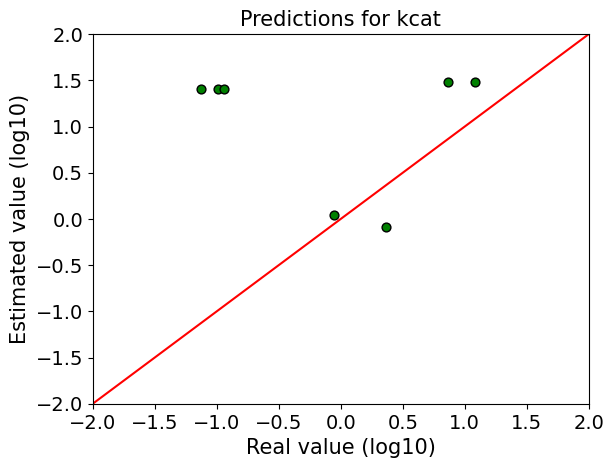

In [70]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

plt.scatter(val_Y,y_val_pred,c='green', edgecolors='black',s=40)
    
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Real value (log10)', fontsize=15)
plt.ylabel('Estimated value (log10)', fontsize=15)
plt.title('Predictions for kcat', fontsize=15)
plt.axline((1, 1), slope=1, c='red')
plt.show()

## 5. Training a model with main substrate information (MACCS) + Temperature + pH:

#### (a) Creating input matrices:

In [71]:
train_X = np.array(list(data_train['GNN FP']))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test['GNN FP']))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [72]:
def cross_validation_mse_gradient_boosting(param):
    num_round = param["num_rounds"]
    del param["num_rounds"]
    param["max_depth"] = int(np.round(param["max_depth"]))
    # param["device"] = "cuda"
    param["tree_method"] = "gpu_hist"
    param["sampling_method"] = "gradient_based"
    
    MSE = []
    R2 = []
    for i in range(5):
        train_index, test_index  = train_indices[i], test_indices[i]
        dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
        dvalid = xgb.DMatrix(train_X[test_index])
        bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
        y_valid_pred = bst.predict(dvalid)
        MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
        R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
    return(-np.mean(R2))

space_gradient_boosting = {
    "learning_rate": hp.choice("learning_rate", [0.01,0.1,0.2]),
    "max_depth": hp.quniform("max_depth", 3, 10, 1),
    # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
    "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
    "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
    "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
    "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
    "num_rounds":  hp.choice("num_rounds", [100,250,500,1000])
    }

rstate = np.random.default_rng(42)
trials = Trials()
best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
            algo=rand.suggest, max_evals = 20, trials=trials, return_argmin=False, rstate=rstate)

print(best)
param = best
param["random_state"] = 42

100%|██████████| 20/20 [07:00<00:00, 21.01s/trial, best loss: -0.3441171009219232]
{'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.2, 'reg_lambda': 0.4}


In [73]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 1.0, 'max_depth': 9.0, 'min_child_weight': 3.0, 'num_rounds': 250, 'reg_alpha': 1.0, 'reg_lambda': 0.8}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
# elif split == "Brassicaceae":
#     param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 3.0, 'min_child_weight': 6.0, 'num_rounds': 500.0, 'reg_alpha': 0.8, 'reg_lambda': 0.4}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 1.0, 'max_depth': 9.0, 'min_child_weight': 3.0, 'num_rounds': 250, 'reg_alpha': 1.0, 'reg_lambda': 0.8}
else:
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 100, 'reg_alpha': 1.0, 'reg_lambda': 0.2}

#### (c) Training and validating model:

In [74]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [75]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_gnn_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_gnn_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_gnn_fp.npy"), np.array(R2))

[0.5871454530412499, 0.13925433873620965, 0.5881081763369254, 0.062187764451187226, 0.765323493490377]
[55.11117403957642, 112.0181603839543, 101.9309770265672, 151.2375539896652, 241.19055176860525]
[0.18474501515385178, -0.04346859989346874, -0.0662453386698103, -0.2686447184889902, -0.028610848776805753]
[18.38545506835733, 26.83485522676887, 38.49019634997491, 71.09524477976768, 68.16355558794318]
[2.861194287191788, 2.5429146884412503, 2.282131124834764, 5.295675073772323, 4.000901240491126]


In [76]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate kcat"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", "y_test_pred_xgboost_gnn_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_gnn_fp.npy"), test_Y)

0.88 282.1339507287 -0.04 100.3183513549 4.3597145385


In [77]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate kcat"] = [10**x for x in data_test["Estimate kcat"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [78]:
train_X = np.array(list(data_train["GNN FP"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["GNN FP"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [79]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.8925511038172249, 9.051726794989093e-23) 277.94443142013847 -0.009040588532341465


In [80]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

1280
167
f0: 42.0
f1: 8.0
f2: 4.0
f4: 12.0
f6: 75.0
f7: 35.0
f8: 3.0
f9: 3.0
f10: 5.0
f11: 6.0
f13: 49.0
f14: 1.0
f19: 25.0
f23: 10.0
f24: 59.0
f30: 121.0
f31: 1.0
f32: 27.0
f33: 15.0
f34: 49.0
f35: 111.0
f36: 23.0
f37: 26.0
f38: 9.0
f40: 3.0
f42: 11.0
f43: 58.0
f45: 11.0
f47: 6.0
f49: 8.0
f50: 63.0
f51: 180.0


#### (e) Validating model:

In [81]:
val_X = np.array(list(data_val["GNN FP"]))
val_X = np.concatenate([val_X, np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate kcat"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

(0.7572201399022959, 0.048700188190710536) 3.314518673022967 0.404952935188554 2.9352887210110903 3.0692814657167147


## 6. Training a model with reaction information (diff-fp) + Temperature + pH:

#### (a) Creating input matrices:

In [82]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [83]:
def cross_validation_mse_gradient_boosting(param):
    num_round = param["num_rounds"]
    del param["num_rounds"]
    param["max_depth"] = int(np.round(param["max_depth"]))
    # param["device"] = "cuda"
    param["tree_method"] = "gpu_hist"
    param["sampling_method"] = "gradient_based"
    
    MSE = []
    R2 = []
    for i in range(5):
        train_index, test_index  = train_indices[i], test_indices[i]
        dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
        dvalid = xgb.DMatrix(train_X[test_index])
        bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
        y_valid_pred = bst.predict(dvalid)
        MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
        R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
    return(-np.mean(R2))

space_gradient_boosting = {
    "learning_rate": hp.choice("learning_rate", [0.01,0.1,0.2]),
    "max_depth": hp.quniform("max_depth", 3, 10, 1),
    # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
    "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
    "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
    "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
    "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
    "num_rounds":  hp.choice("num_rounds", [100,250,500,1000])
    }

rstate = np.random.default_rng(42)
trials = Trials()
best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
            algo=rand.suggest, max_evals = 20, trials=trials, return_argmin=False, rstate=rstate)

print(best)
param = best
param["random_state"] = 42

100%|██████████| 20/20 [54:12<00:00, 162.63s/trial, best loss: -0.18678228348111556]
{'learning_rate': 0.01, 'max_delta_step': 5.0, 'max_depth': 5.0, 'min_child_weight': 3.0, 'num_rounds': 1000, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.8}


In [84]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4.0, 'max_depth': 7.0, 'min_child_weight': 2.0, 'num_rounds': 100, 'reg_alpha': 0.0, 'reg_lambda': 0.2}
elif split == "Arabidopsis":
    param = {"random_state": 42,'learning_rate': 0.01, 'max_delta_step': 5.0, 'max_depth': 5.0, 'min_child_weight': 3.0, 'num_rounds': 1000, 'reg_alpha': 0.6, 'reg_lambda': 0.8}
# elif split == "Brassicaceae":
#     param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 4.0, 'num_rounds': 750.0, 'reg_alpha': 1.0, 'reg_lambda': 1.0}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 5.0, 'max_depth': 5.0, 'min_child_weight': 3.0, 'num_rounds': 1000, 'reg_alpha': 0.6, 'reg_lambda': 0.8}
else:
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 4.0, 'max_depth': 5.0, 'min_child_weight': 3.0, 'num_rounds': 250, 'reg_alpha': 0.8, 'reg_lambda': 0.2}

#### (c) Training and validating model:

In [85]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [86]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_diff_fp.npy"), np.array(R2))

[0.5631438708400616, 0.05027151695770309, 0.5456501666447128, 0.3749267040259386, 0.5140069131528338]
[63.70561365887703, 111.89288102797644, 94.9497643709136, 145.69186357983483, 230.56602475673972]
[-0.08935528338686893, -0.041135907171284014, 0.0748065400200314, -0.1773113292516515, 0.06001452638027471]
[23.8577916129827, 26.06651132282667, 36.73082053570684, 67.47309790036167, 66.58103758491804]
[4.432538637058628, 2.4230660338546652, 2.3507574374378812, 6.39886056347583, 4.030397060552453]


In [87]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate kcat"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", "y_test_pred_xgboost_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_diff_fp.npy"), test_Y)

0.851 257.166311107 0.136 89.0382672053 4.276003892


In [88]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate kcat"] = [10**x for x in data_test["Estimate kcat"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [89]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [90]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.8905396548249721, 1.5461809686023638e-22) 233.9643513150502 0.2850230170751945


In [91]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

1280
167
f4: 76.0
f5: 16.0
f6: 23.0
f11: 12.0
f15: 13.0
f22: 31.0
f27: 53.0
f28: 15.0
f29: 9.0
f30: 19.0
f43: 9.0
f53: 40.0
f61: 15.0
f75: 42.0
f92: 10.0
f94: 32.0
f95: 9.0
f115: 4.0
f124: 48.0
f125: 4.0
f130: 21.0
f132: 50.0
f134: 22.0
f137: 6.0
f138: 27.0
f153: 3.0
f161: 1.0
f163: 25.0
f169: 3.0
f197: 3.0
f201: 9.0
f202: 1.0
f205: 32.0
f223: 5.0
f232: 3.0
f236: 12.0
f244: 1.0
f254: 21.0
f262: 23.0
f298: 12.0
f303: 1.0
f311: 15.0
f312: 12.0
f331: 1.0
f334: 8.0
f339: 22.0
f363: 24.0
f371: 7.0
f374: 24.0
f412: 6.0
f426: 5.0
f439: 23.0
f460: 25.0
f477: 15.0
f479: 90.0
f500: 15.0
f529: 1.0
f542: 49.0
f546: 1.0
f571: 5.0
f594: 1.0
f682: 3.0
f704: 41.0
f772: 36.0
f776: 15.0
f781: 27.0
f796: 1.0
f816: 15.0
f831: 2.0
f844: 3.0
f861: 1.0
f863: 1.0
f901: 58.0
f909: 6.0
f926: 10.0
f982: 51.0
f1025: 18.0
f1032: 22.0
f1033: 11.0
f1038: 2.0
f1041: 26.0
f1048: 1.0
f1074: 10.0
f1082: 37.0
f1089: 2.0
f1091: 40.0
f1104: 52.0
f1138: 1.0
f1143: 8.0
f1151: 23.0
f1154: 8.0
f1162: 29.0
f1206: 10.0
f1214: 7.

#### (e) Validating model:

In [92]:
val_X = np.array(list(data_val["difference_fp"]))
val_X = np.concatenate([val_X, np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate kcat"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

(0.8387856846270039, 0.018339432531759313) 6.19005500362308 -1.0753884400752138 5.267087993057238 6.212220087564255


## 7. Training a model with reaction and main substrate information (diff-fp/MACCS) + Temperature + pH:

#### (a) Creating input matrices:

In [93]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [94]:
def cross_validation_mse_gradient_boosting(param):
    num_round = param["num_rounds"]
    del param["num_rounds"]
    param["max_depth"] = int(np.round(param["max_depth"]))
    # param["device"] = "cuda"
    param["tree_method"] = "gpu_hist"
    param["sampling_method"] = "gradient_based"
    
    MSE = []
    R2 = []
    for i in range(5):
        train_index, test_index  = train_indices[i], test_indices[i]
        dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
        dvalid = xgb.DMatrix(train_X[test_index])
        bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
        y_valid_pred = bst.predict(dvalid)
        MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
        R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
    return(-np.mean(R2))

space_gradient_boosting = {
    "learning_rate": hp.choice("learning_rate", [0.01,0.1,0.2]),
    "max_depth": hp.quniform("max_depth", 3, 10, 1),
    # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
    "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
    "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
    "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
    "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
    "num_rounds":  hp.choice("num_rounds", [100,250,500,1000])
    }

rstate = np.random.default_rng(42)
trials = Trials()
best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
            algo=rand.suggest, max_evals = 20, trials=trials, return_argmin=False, rstate=rstate)

print(best)
param = best
param["random_state"] = 42

 50%|█████     | 10/20 [21:00<21:00, 126.06s/trial, best loss: -0.38719906875681] 


KeyboardInterrupt: 

In [95]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 2.0, 'max_depth': 8.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.4, 'reg_lambda': 0.0}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 5.0, 'max_depth': 5.0, 'min_child_weight': 3.0, 'num_rounds': 1000, 'reg_alpha': 0.6, 'reg_lambda': 0.8}
# elif split == "Brassicaceae":
#     param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 4.0, 'num_rounds': 250.0, 'reg_alpha': 0.8, 'reg_lambda': 0.4}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 5.0, 'max_depth': 5.0, 'min_child_weight': 3.0, 'num_rounds': 1000, 'reg_alpha': 0.6, 'reg_lambda': 0.8}
else:
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 1.0, 'max_depth': 9.0, 'min_child_weight': 3.0, 'num_rounds': 250, 'reg_alpha': 1.0, 'reg_lambda': 0.8}

#### (c) Training and validating model:

In [96]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [97]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_gnn_fp_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_gnn_fp_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_gnn_fp_diff_fp.npy"), np.array(R2))

[0.599064724463016, 0.05937198035115421, 0.671584213037929, 0.3687836041043183, 0.4280071166749206]
[146.10987127486226, 112.91050624419582, 84.91440743119493, 139.19979607901868, 223.04843648319775]
[-4.730245824039351, -0.060159529840287274, 0.2600412023509202, -0.07472641773061883, 0.12031155988725062]
[43.9531403420476, 27.237584784845453, 31.652938037273113, 62.12253026888723, 62.36359233552613]
[3.0498110223001738, 2.4578744135562793, 2.02623824007597, 6.473646025509832, 3.9951894972332926]


In [98]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate kcat"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", "y_test_pred_xgboost_gnn_fp_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_gnn_fp_diff_fp.npy"), test_Y)

0.883 216.9381436655 0.385 71.1156737029 3.633731367


In [99]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate kcat"] = [10**x for x in data_test["Estimate kcat"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [100]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X,  np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [101]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.8958148250862655, 3.7106686508608816e-23) 186.16653162214917 0.5473152163396804


In [102]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

1280
167
f4: 167.0
f5: 138.0
f6: 59.0
f10: 36.0
f11: 66.0
f13: 25.0
f22: 45.0
f23: 7.0
f26: 27.0
f27: 41.0
f28: 123.0
f30: 15.0
f37: 5.0
f39: 1.0
f40: 10.0
f43: 32.0
f45: 17.0
f48: 13.0
f53: 38.0
f60: 12.0
f61: 23.0
f71: 35.0
f75: 71.0
f88: 47.0
f92: 163.0
f93: 122.0
f94: 42.0
f95: 9.0
f106: 26.0
f115: 34.0
f124: 169.0
f125: 7.0
f134: 7.0
f137: 45.0
f153: 9.0
f157: 38.0
f158: 145.0
f161: 31.0
f169: 5.0
f177: 5.0
f178: 11.0
f181: 5.0
f190: 24.0
f191: 13.0
f194: 20.0
f197: 7.0
f201: 25.0
f202: 48.0
f205: 34.0
f222: 28.0
f228: 28.0
f232: 15.0
f233: 9.0
f236: 75.0
f241: 12.0
f242: 37.0
f244: 101.0
f254: 23.0
f255: 1.0
f262: 18.0
f270: 1.0
f285: 1.0
f298: 3.0
f303: 1.0
f311: 15.0
f312: 23.0
f318: 3.0
f331: 48.0
f334: 133.0
f339: 5.0
f363: 6.0
f371: 4.0
f374: 208.0
f377: 4.0
f426: 9.0
f431: 66.0
f439: 56.0
f441: 21.0
f453: 11.0
f477: 12.0
f479: 90.0
f530: 9.0
f542: 48.0
f563: 68.0
f594: 3.0
f632: 9.0
f648: 5.0
f658: 9.0
f690: 43.0
f704: 13.0
f711: 1.0
f728: 9.0
f747: 42.0
f767: 44.0
f772: 23

#### (e) Validating model:

In [103]:
val_X = np.array(list(data_val["difference_fp"]))
val_X = np.concatenate([val_X,  np.array(list(data_val["GNN FP"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate kcat"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

(0.8305995449928356, 0.02066070926168422) 12.567324877859663 -7.55452818506758 9.114307119552704 5.292299269589129


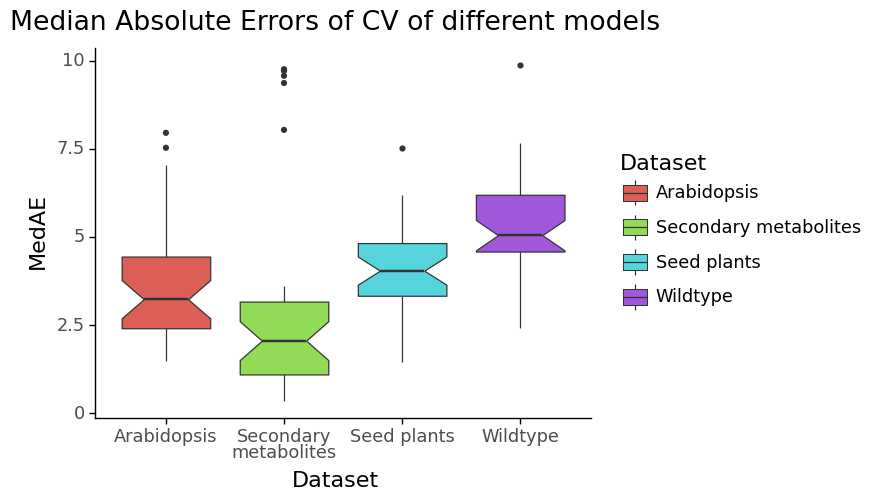

<ggplot: (-9223371940881338632)>

In [104]:
full = [1.460336438624098, 4.048723055930708, 4.382216822907296, 3.4035051959407796, 6.081597900745842, 1.4936266065875201, 2.741378524607981, 5.186047587214748, 2.8199154275650926, 3.572314037324026, 1.6737416018703661, 3.5594747781752405, 3.624624456475313, 3.4378782980994016, 4.771170423977214, 1.76030820442841, 4.011092359925896, 4.326894582209751, 4.244831595249858, 7.524212568520143, 3.4364884832052454, 5.721431624843737, 5.0375646560236165, 4.205159222675065, 4.888694290237481, 2.2557283629592937, 3.269925548257523, 5.488163958068133, 4.223485541827714, 6.1943252987709965, 2.338020492417291, 4.388852365976196, 4.104322683898047, 4.945531363245488, 4.01233399008186]
# brassicaceae = [2.5458135124152736, 5.498346178977734, 4.064283820146354, 2.3520865855938347, 1.4370359399514743, ]
arabidopsis = [2.0906529382059738, 1.9186151673217715, 2.2998538889561777, 7.530529440164756, 2.684634067293295, 2.041897342963628, 1.9142352788581876, 3.3300094198861205, 4.990709452611035, 3.332588251761812, 1.5003848679167908, 2.5993998353563024, 1.9194007932602783, 6.224265741871996, 2.880758728006489, 2.1541755816753563, 2.231434544538099, 5.317850575341532, 6.1802430183461965, 3.3428719958700177, 3.5160445914787744, 3.1178141018729844, 2.7446860465879634, 6.896208672947187, 4.190658411973807, 4.203037663698579, 3.4287597970455392, 2.660559608408761, 7.953968425728287, 4.691369201382818, 3.6098267108998883, 2.9452585381277867, 2.531614778685275, 7.033005536848556, 3.2383988517267097]
wildtype = [5.018775559941702, 5.440428374591378, 3.266129715510677, 4.258732088748817, 7.417007050976586, 4.842596787914799, 7.657834543821979, 2.435841539721939, 4.939176942311719, 6.437473461645331, 5.053602144631077, 6.999935354654321, 3.478343868689091, 5.096459350964102, 6.84664085174432, 4.6404535352089695, 7.339804601846999, 3.410300892714605, 4.839999999999999, 5.292416651069285, 5.868930227974666, 6.923293044705776, 4.342616390234044, 4.65969214292545, 9.884373502667799, 5.734414990566345, 5.76024243945227, 4.536122819813045, 4.537693389940214, 6.107259020962475, 4.731227574996338, 6.287600311820375, 4.744261958216651, 4.299059686151046, 5.646855798492281]
secondary = [2.489761383400407, 9.71232344209233, 0.7051183867396502, 2.033625824864438, 1.7384722813513696, 1.9902380233115824, 9.746969765898553, 0.7792416059713768, 2.5421773085259587, 1.12194119829723, 1.3086932940726628, 9.751743404865811, 0.9326928791482589, 1.872884538013162, 1.1069711746016548, 1.1050833058758662, 9.722487094251552, 0.6093839093212603, 3.4446752979272284, 1.229596373560576, 2.381245511666192, 9.366303276239236, 0.8149169982920881, 2.8002763263589268, 0.8773225522077258, 2.6688083710327133, 8.037275630371614, 0.5651459843250255, 3.5998748250133983, 2.0642603800568993, 2.5722755713513012, 9.570142460100515, 0.361462625966383, 2.3138521667546317, 2.8979872690227144]

data_frame = pd.DataFrame({"Seed plants": full, "Arabidopsis" : arabidopsis,
                             "Wildtype" : wildtype, "Secondary metabolites" : secondary}).melt()
from plotnine import (
    ggplot,
    aes,
    geom_boxplot,
    labs,
    theme_classic,
    scale_x_discrete
)

import textwrap

(
    ggplot(data_frame, aes(x = "variable", y="value"))
    + geom_boxplot(aes(fill="variable"), notch=True) 
    + scale_x_discrete(labels= [textwrap.fill(label, width=11) for label in ["Arabidopsis", "Secondary metabolites", "Seed plants", "Wildtype"]])
    + labs(title="Median Absolute Errors of CV of different models", x="Dataset", y="MedAE", fill="Dataset")
    + theme_classic(base_size=16)
)
